In [1]:
import pickle
import json
import numpy as np
import os

import tensorflow_core as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import pandas as pd
import seaborn as sb
import scipy as sp
import sklearn.preprocessing as skp
import sklearn.model_selection as skm

import sys

np.set_printoptions(threshold=sys.maxsize)

In [2]:
scaler = skp.StandardScaler()

In [3]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

def read_data(directory, is_train):
    names = unpickle('{}/batches.meta'.format(directory))['label_names']

    data, labels = [], []
    for i in range(1, 6):
        filename = '{}/data_batch_{}'.format(directory, i)
        batch_data = unpickle(filename)
        if len(data) > 0:
            data = np.vstack((data, batch_data['data']))
            labels = np.hstack((labels, batch_data['labels']))
        else:
            data = batch_data['data']
            labels = batch_data['labels']

    data, origional_data = clean(data, is_train)
    data = data.astype(np.float32)

    return names, data, origional_data, labels

def clean(data, is_train):    
    # 3072 = 3 * 32 * 32
    imgs = np.reshape(data, (data.shape[0], 3, 32, 32))
    original_imgs = np.transpose(imgs, (0,2,3,1))
    grayscale_imgs = np.mean(imgs, axis=1)
    
    # crop to 24 x 24 image, from center
    cropped_imgs = grayscale_imgs[:, 4:28, 4:28]
    
    # reshape to linear array
    img_data = np.reshape(cropped_imgs, (data.shape[0], -1))
    
    if is_train:
        scaler.fit(img_data)
    
    return scaler.transform(img_data), original_imgs

In [4]:
def plot_images(images, label_ids, label_names, is_original):
    
    # fig_s = plt.gcf()
    # fig_s.set_size_inches(30, 30)
    
    # 3x3 grid
    fig, axes = plt.subplots(6, 6, figsize=(10,10))
    fig.tight_layout()

    # fig.subplots_adjust(hspace=0.5)

    for i, ax in enumerate(axes.flat): # from 0 -> 8

        # Show image.
        if is_original:
            ax.imshow(images[i],
                      interpolation="spline16")
        else:
            ax.imshow(np.reshape(images[i, :], (24, 24)),
                      interpolation="spline16")
            
        _class = label_names[label_ids[i]]
        
        xlabel = "{0}".format(_class)

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()
    

In [5]:
names, data, original_data, labels = read_data(
    os.path.join(os.getcwd(), "data"), is_train=True)

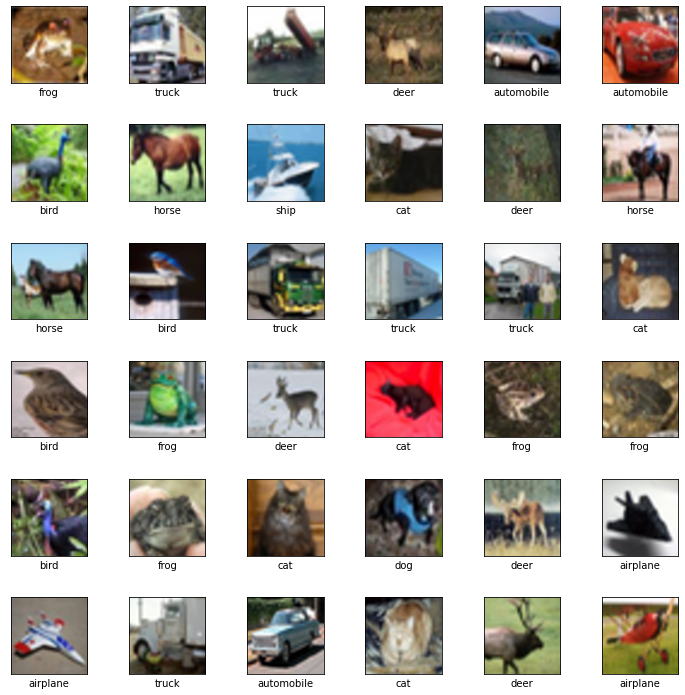

In [6]:
plot_images(original_data, labels, names, is_original=True)

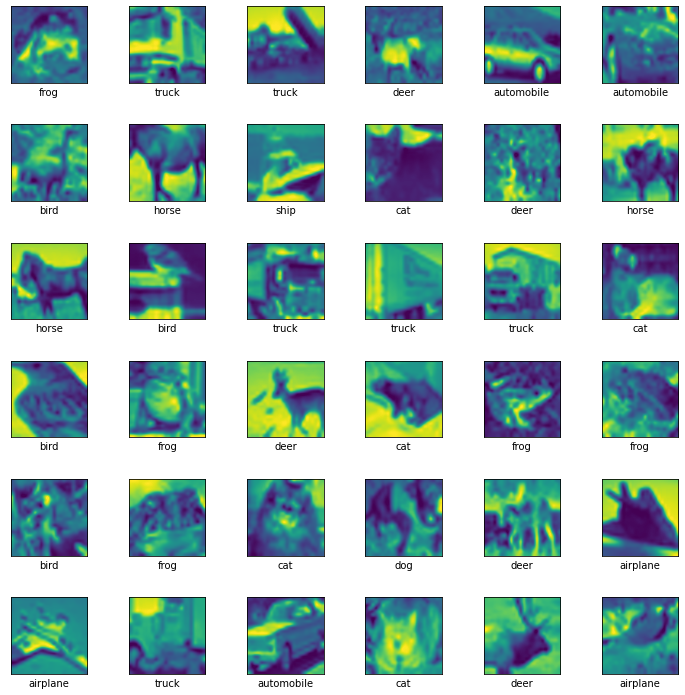

In [7]:
plot_images(data, labels, names, is_original=False)

In [8]:
def show_weights(W, filename=None):
    plt.figure()
    plt.gcf().set_size_inches(8, 8)
    # 32 filter, organized in 4 * 8 matrix
    rows, cols = 4, 8
    for i in range(np.shape(W)[3]):
        img = W[:, :, 0, i]
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='Greys_r', interpolation='none')
        plt.axis('off')
    if filename:
        plt.savefig(filename)
    else:
        plt.show()

In [9]:
def show_conv_results(data, filename=None):
    plt.figure()
    plt.gcf().set_size_inches(8, 8)
    # 32 filter, organized in 4 * 8 matrix
    rows, cols = 4, 8
    for i in range(np.shape(data)[3]):
        img = data[0, :, :, i]
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='Greys_r', interpolation='none')
        plt.axis('off')
    if filename:
        plt.savefig(filename)
    else:
        plt.show()

In [10]:
raw_data = data[4, :]

# -1 = full size batch
# compressed image size = 24 * 24
# number of channel = 1
x = tf.reshape(raw_data, shape=[-1, 24, 24, 1])

# 5 x 5 filter size
# number of channel = 1
# number of filter = 32
W = tf.Variable(tf.random_normal([5, 5, 1, 32]))

# strides of sliding window for each input dimension
strds = [1, 1, 1, 1]
conv = tf.nn.conv2d(x, W, strides=strds, padding='SAME')

print("First convolutional layer")
print(conv.get_shape())

# 1-dimention bias, restricted to number of filter in a channel
b = tf.Variable(tf.random_normal([32]))
conv_with_b = tf.nn.bias_add(conv, b)

First convolutional layer
(1, 24, 24, 32)


In [11]:
# activation function, using relu
conv_out = tf.nn.relu(conv_with_b)

k = 2
maxpool = tf.nn.max_pool(conv_out, ksize=[1, k, k, 1], \
                strides=[1, k, k, 1], padding='SAME')

A random filter


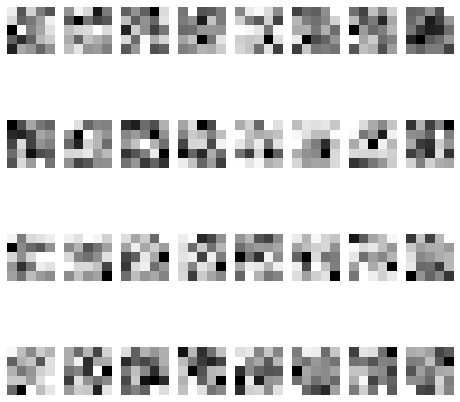

convolution results:
(1, 24, 24, 32)


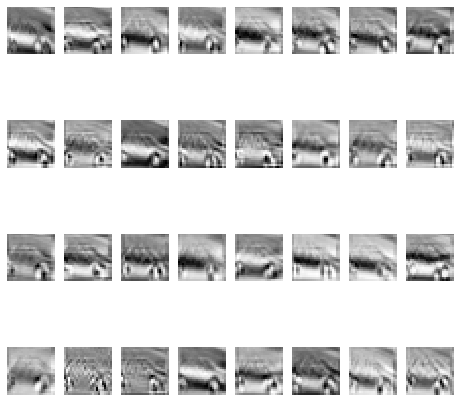

convolution with bias and relu:
(1, 24, 24, 32)


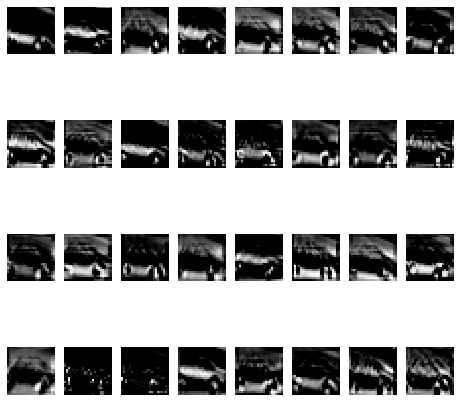

maxpool after all the convolutions:
(1, 12, 12, 32)


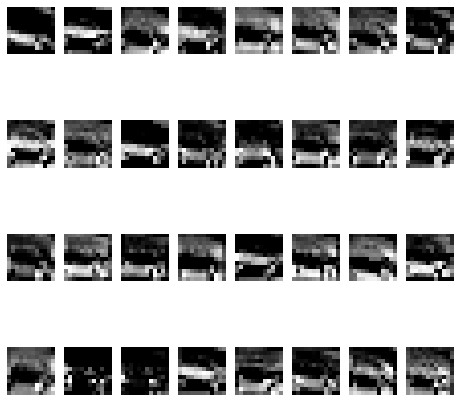

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    W_val = sess.run(W)
    print('A random filter')
    show_weights(W_val)

    conv_val = sess.run(conv)
    print('convolution results:')
    print(np.shape(conv_val))
    show_conv_results(conv_val)
    

    conv_out_val = sess.run(conv_out)
    print('convolution with bias and relu:')
    print(np.shape(conv_out_val))
    show_conv_results(conv_out_val)


    maxpool_val = sess.run(maxpool)
    print('maxpool after all the convolutions:')
    print(np.shape(maxpool_val))
    show_conv_results(maxpool_val)